In [8]:
import pandas as pd


df = pd.read_csv("../data/UpdatedResumeDataSet.csv")


print("Shape:", df.shape)
print("\nColumns:", df.columns)
df.head()


Shape: (962, 2)

Columns: Index(['Category', 'Resume'], dtype='object')


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [9]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"http\S+", " ", text)        # remove links
    text = re.sub(r"[^a-zA-Z ]", " ", text)     # remove symbols
    text = text.lower()                         # lowercase
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df["cleaned_resume"] = df["Resume"].apply(clean_text)

df[["Category", "cleaned_resume"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nityam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Category,cleaned_resume
0,Data Science,skills programming languages python pandas num...
1,Data Science,education details may may b e uit rgpv data sc...
2,Data Science,areas interest deep learning control system de...
3,Data Science,skills r python sap hana tableau sap hana sql ...
4,Data Science,education details mca ymcaust faridabad haryan...


In [10]:
df.to_csv("../data/cleaned_resumes.csv", index=False)
print("Cleaned data saved.")


Cleaned data saved.


In [11]:
from sklearn.model_selection import train_test_split

X = df["cleaned_resume"]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (769,)
Test size: (193,)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (769, 5000)


In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [14]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))


Accuracy: 0.9948186528497409

Report:
                            precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
                   Had

In [15]:
import pickle

# Save TF-IDF vectorizer
with open("../src/tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save trained model
with open("../src/model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model and vectorizer saved.")


Model and vectorizer saved.


In [16]:
def predict_category(resume_text):
    cleaned = clean_text(resume_text)
    vectorized = tfidf.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    return prediction


In [17]:
sample_resume = """
Experienced Python developer skilled in machine learning,
data analysis, pandas, numpy, and deep learning.
"""

print("Predicted category:", predict_category(sample_resume))


Predicted category: Data Science


In [18]:
sample_resume = """
C++,data structure,java.
"""

print("Predicted category:", predict_category(sample_resume))

Predicted category: Java Developer


In [19]:
sample_resume = """
experienced in c++ and data structure.
"""

print("Predicted category:", predict_category(sample_resume))

Predicted category: Data Science


In [20]:
skills_list = [
    "python", "java", "sql", "machine learning", "deep learning",
    "tensorflow", "pytorch", "spring", "react", "node", "aws",
    "docker", "kubernetes", "data analysis", "pandas", "numpy",
    "excel", "communication", "leadership"
]


In [21]:
def extract_skills(text):
    text = text.lower()
    found_skills = [skill for skill in skills_list if skill in text]
    return list(set(found_skills))


In [22]:
resume_text = """
Python developer with experience in machine learning,
deep learning, pandas, numpy, and AWS.
"""

print("Extracted skills:", extract_skills(resume_text))


Extracted skills: ['deep learning', 'aws', 'machine learning', 'numpy', 'python', 'pandas']


In [23]:
def ats_score(resume_text, job_description):
    resume_skills = extract_skills(resume_text)
    jd_skills = extract_skills(job_description)

    if len(jd_skills) == 0:
        return 0

    match_count = len(set(resume_skills) & set(jd_skills))
    score = (match_count / len(jd_skills)) * 100

    return round(score, 2), resume_skills, jd_skills


In [24]:
resume = """
Python developer skilled in machine learning, pandas, numpy, and AWS.
"""

job_desc = """
Looking for a Python developer with machine learning, AWS, Docker, and SQL experience.
"""

score, r_skills, j_skills = ats_score(resume, job_desc)

print("Resume skills:", r_skills)
print("JD skills:", j_skills)
print("ATS Score:", score, "%")


Resume skills: ['aws', 'machine learning', 'numpy', 'python', 'pandas']
JD skills: ['aws', 'docker', 'machine learning', 'python', 'sql']
ATS Score: 60.0 %


In [25]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression



In [26]:
# Logistic Regression (already trained earlier)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

# Linear SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [27]:
models = {
    "Logistic Regression": log_reg,
    "Linear SVM": svm_model,
    "Naive Bayes": nb_model
}

for name, m in models.items():
    preds = m.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {round(acc*100, 2)}%")


Logistic Regression Accuracy: 99.48%
Linear SVM Accuracy: 99.48%
Naive Bayes Accuracy: 98.96%


In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", round(grid.best_score_ * 100, 2), "%")


c:\Users\Nityam\Desktop\AI RESUME ANALYZER\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Best Parameters: {'C': 10, 'solver': 'liblinear'}
Best CV Accuracy: 99.61 %


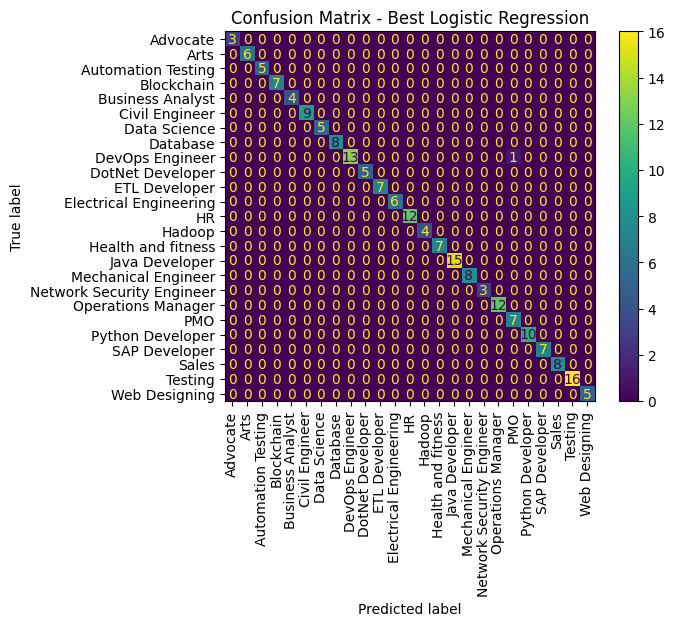

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, xticks_rotation=90)
plt.title("Confusion Matrix - Best Logistic Regression")
plt.show()


In [30]:
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert resumes to embeddings
X_train_bert = bert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_bert = bert_model.encode(X_test.tolist(), show_progress_bar=True)

print("BERT embedding shape:", X_train_bert.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Nityam\Desktop\AI RESUME ANALYZER\venv\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nityam\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

BERT embedding shape: (769, 384)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

bert_clf = LogisticRegression(max_iter=1000)
bert_clf.fit(X_train_bert, y_train)

y_pred_bert = bert_clf.predict(X_test_bert)

bert_acc = accuracy_score(y_test, y_pred_bert)
print("BERT Logistic Regression Accuracy:", round(bert_acc * 100, 2), "%")


BERT Logistic Regression Accuracy: 96.89 %


In [32]:
tfidf_acc = accuracy_score(y_test, best_model.predict(X_test_tfidf))

print("TF-IDF Best Accuracy:", round(tfidf_acc * 100, 2), "%")
print("BERT Accuracy:", round(bert_acc * 100, 2), "%")


TF-IDF Best Accuracy: 99.48 %
BERT Accuracy: 96.89 %


In [33]:
import pickle

best_model = grid.best_estimator_

with open("../src/model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Best tuned model saved successfully.")


Best tuned model saved successfully.


In [34]:
best_model


,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'
